### Distance metrics and optimization algorithms in FFTimbre

We assess how closely a generated spectrum matches a target spectrum using objective functions that guide the optimizer during synthesis from frequency/amplitude tables. This overview aligns with the definitions used in `distances_demo.ipynb`.

- **Itakura–Saito**: Ratio- and log-based similarity; sensitive to low-energy regions.
- **Spectral convergence**: Normalized difference between target and generated magnitudes.
- **Cosine similarity**: Directional alignment (angle) between spectra.
- **Euclidean distance**: Straight-line distance in spectral space.
- **Manhattan distance**: Sum of absolute spectral differences.
- **Kullback–Leibler divergence**: Divergence between spectral distributions.
- **Pearson correlation coefficient**: Linear correlation between spectra.
- **MFCC distance**: Distance between mean MFCCs of the signals.

Optimization algorithms used in this notebook:
- **Basin-Hopping (BH)**: Global–local strategy combining random perturbations with local minimization (here L-BFGS-B) to hop between basins of attraction.
- **Differential Evolution (DE)**: Population-based global search with mutation and crossover; robust on nonconvex, nonsmooth loss surfaces; easily parallelizable.
- **Dual Annealing (DA)**: Annealing-based global optimizer with bounds-aware proposals and local refinement; suited for rugged landscapes.

In this demo, we minimize a chosen distance (default: Itakura–Saito) starting from `Q1` under bounds `[0, 5]`, record intermediate solutions from each optimizer, and render GIFs to visualize their trajectories toward the target spectrum.


Saved GIF to: c:\Users\egorp\Nextcloud\code\public_repos\FFTimbre\rendered_gifs\basinhopping.gif


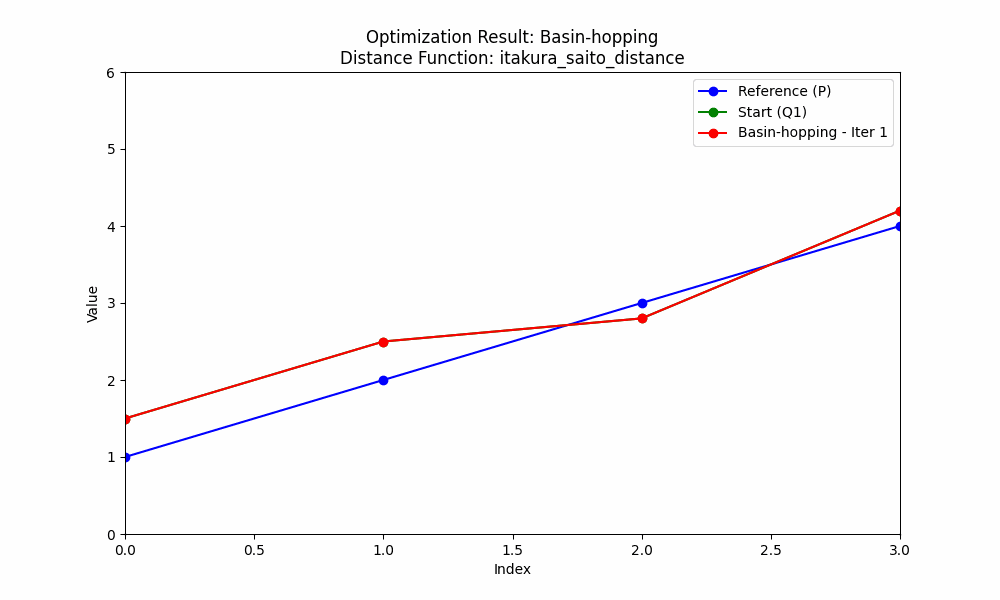

Saved GIF to: c:\Users\egorp\Nextcloud\code\public_repos\FFTimbre\rendered_gifs\differential_evolution.gif


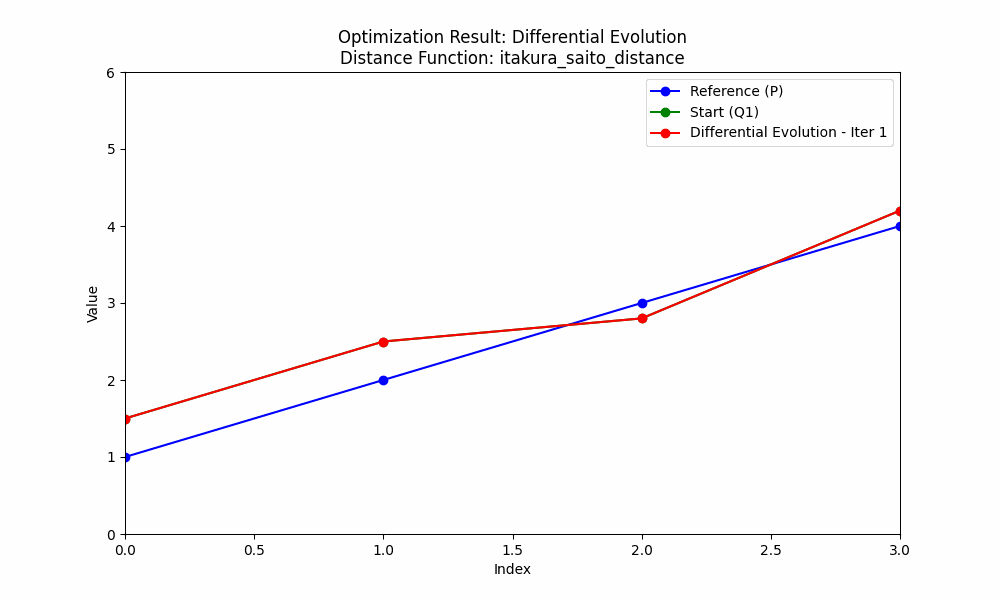

Saved GIF to: c:\Users\egorp\Nextcloud\code\public_repos\FFTimbre\rendered_gifs\dual_annealing.gif


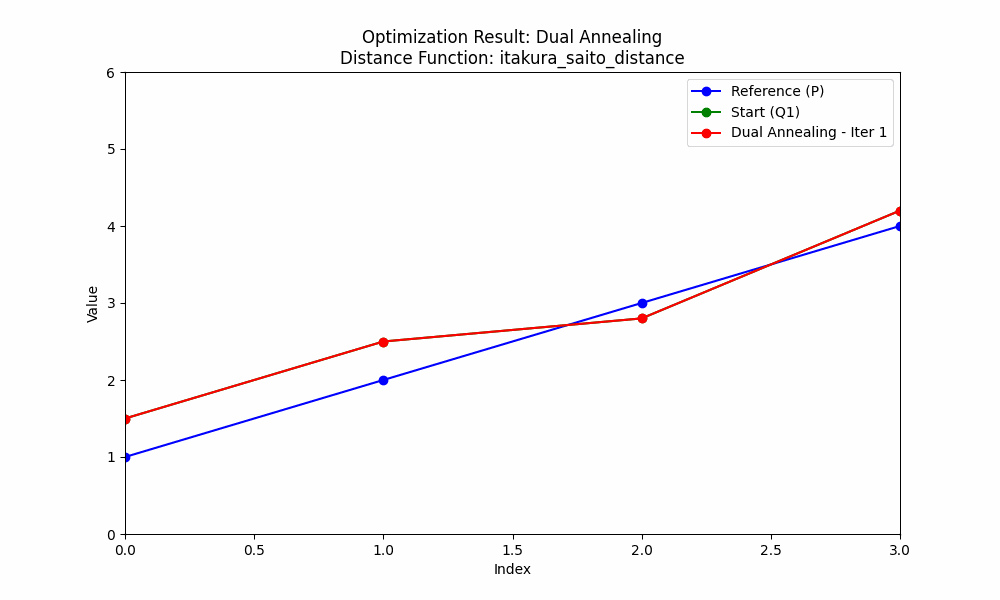

In [4]:
import numpy as np
from scipy.optimize import basinhopping, differential_evolution, dual_annealing
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from PIL import Image
import os, io, tempfile
from IPython.display import display, Image as IPyImage

# Define the sequences
P = np.array([1.0, 2.0, 3.0, 4.0])
Q1 = np.array([1.5, 2.5, 2.8, 4.2])

# Small epsilon to avoid NaN calculations
epsilon = 1e-10

# Define various distance measures
def cosine_distance(Q, P=P):
    similarity = np.dot(P, Q) / (np.linalg.norm(P) * np.linalg.norm(Q))
    distance = 1 - similarity
    return distance

def itakura_saito_distance(Q, P=P):
    P_safe = np.maximum(P, epsilon)
    Q_safe = np.maximum(Q, epsilon)
    ratio = P_safe / Q_safe
    return np.sum(ratio - np.log(ratio) - 1)

def spectral_convergence_distance(Q, P=P):
    return np.linalg.norm(P - Q) / (np.linalg.norm(P) + epsilon)

def euclidean_distance(Q, P=P):
    return np.linalg.norm(P - Q)

def manhattan_distance(Q, P=P):
    return np.sum(np.abs(P - Q))

def kullback_leibler_divergence(Q, P=P):
    P_safe = np.maximum(P, epsilon)
    Q_safe = np.maximum(Q, epsilon)
    return np.sum(P_safe * np.log(P_safe / Q_safe))

def pearson_correlation_distance(Q, P=P):
    return 1 - np.corrcoef(P, Q)[0, 1]

# Choose the distance function
distance_function = itakura_saito_distance  # Change this to use a different distance measure
distance_function_name = distance_function.__name__

# Control the maximum number of iterations via variable
max_iterations = 25

# Output options
DISPLAY_GIFS = True   # show GIFs inline in the notebook
SAVE_GIFS = True      # save GIF files to disk
OUTPUT_DIR = "rendered_gifs"  # folder to save GIFs when SAVE_GIFS is True

# Animation timing (decoupled from max_iterations)
GIF_DELAY_MS = 250  # milliseconds per frame in the final GIF and preview
GIF_FPS = max(1, int(round(1000.0 / max(1, GIF_DELAY_MS))))  # derived fps for Pillow writer

# Initialize lists to store results for each iteration
bh_results = [Q1.copy()]
de_results = [Q1.copy()]
da_results = [Q1.copy()]

# Callback function to store each iteration's results
def store_results(xk, f=None, accept=None):
    if len(bh_results) < max_iterations:
        bh_results.append(np.copy(xk))

# Shared bounds to prevent invalid values during optimization
BOUNDS = [(0 + epsilon, 5)] * len(P)

# Run Basin-hopping optimization (with box constraints via L-BFGS-B bounds)
minimizer_kwargs = {"method": "L-BFGS-B", "bounds": BOUNDS}
result_bh = basinhopping(distance_function, Q1, minimizer_kwargs=minimizer_kwargs, niter=max_iterations, callback=store_results)

# Fill remaining iterations with the last result
while len(bh_results) < max_iterations:
    bh_results.append(bh_results[-1])

# Run Differential Evolution optimization and store each iteration's results
def de_callback(xk, convergence=None):
    if len(de_results) < max_iterations:
        de_results.append(np.copy(xk))

result_de = differential_evolution(distance_function, bounds=BOUNDS, maxiter=max_iterations, callback=de_callback)

# Fill remaining iterations with the last result
while len(de_results) < max_iterations:
    de_results.append(de_results[-1])

# Run Dual Annealing optimization and store each iteration's results
def da_callback(xk, f, context=None):
    if len(da_results) < max_iterations:
        da_results.append(np.copy(xk))

result_da = dual_annealing(distance_function, bounds=BOUNDS, maxiter=max_iterations, callback=da_callback)

# Fill remaining iterations with the last result
while len(da_results) < max_iterations:
    da_results.append(da_results[-1])

# Create animations
fig, ax = plt.subplots(figsize=(10, 6))

def animate(i, results, method_name, distance_function_name):
    ax.clear()
    ax.plot(P, 'bo-', label='Reference (P)')
    ax.plot(Q1, 'go-', label='Start (Q1)')
    ax.plot(results[i], 'ro-', label=f'{method_name} - Iter {i+1}')
    ax.set_title(f'Optimization Result: {method_name}\nDistance Function: {distance_function_name}')
    ax.set_xlabel('Index')
    ax.set_ylabel('Value')
    ax.set_xlim(0, len(P) - 1)
    ax.set_ylim(0, 6)
    ax.legend()

def create_animation(results, method_name, filename, distance_function_name):
    ani = animation.FuncAnimation(
        fig,
        animate,
        frames=max_iterations,
        fargs=(results, method_name, distance_function_name),
        repeat=False,
        interval=GIF_DELAY_MS,
    )

    saved_path = None
    if SAVE_GIFS:
        os.makedirs(OUTPUT_DIR, exist_ok=True)
        saved_path = os.path.join(OUTPUT_DIR, filename)
        ani.save(saved_path, writer='pillow', fps=GIF_FPS)
        print(f"Saved GIF to: {os.path.abspath(saved_path)}")

    if DISPLAY_GIFS:
        if saved_path is not None:
            display(IPyImage(filename=saved_path))
        else:
            with tempfile.NamedTemporaryFile(suffix=".gif", delete=False) as tmp:
                tmp_path = tmp.name
            try:
                ani.save(tmp_path, writer='pillow', fps=GIF_FPS)
                display(IPyImage(filename=tmp_path))
            finally:
                try:
                    os.remove(tmp_path)
                except OSError:
                    pass

# Create and save/display the animations
create_animation(bh_results, "Basin-hopping", "basinhopping.gif", distance_function_name)
create_animation(de_results, "Differential Evolution", "differential_evolution.gif", distance_function_name)
create_animation(da_results, "Dual Annealing", "dual_annealing.gif", distance_function_name)

plt.close(fig)  # Close the plot to prevent it from displaying in the notebook
